In [1]:
#Import Libraries
import pandas as pd
import numpy as np
import seaborn as sb

import matplotlib.pyplot as plt
%matplotlib inline

from scipy.stats import norm, skew #for some statistics
from scipy import stats #qqplot
import statsmodels.api as sm #for decomposing the trends, seasonality etc.

from statsmodels.tsa.statespace.sarimax import SARIMAX

In [2]:
#Import the data and parse dates.
df  = pd.read_csv('F:/New Project Forecasting/Product Demand.csv', parse_dates=['Date'])

In [3]:
df.head()

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
0,Product_0993,Whse_J,Category_028,2012-07-27,100
1,Product_0979,Whse_J,Category_028,2012-01-19,500
2,Product_0979,Whse_J,Category_028,2012-02-03,500
3,Product_0979,Whse_J,Category_028,2012-02-09,500
4,Product_0979,Whse_J,Category_028,2012-03-02,500


In [4]:
df.shape

(1048575, 5)

In [7]:
df.dtypes

Product_Code                object
Warehouse                   object
Product_Category            object
Date                datetime64[ns]
Order_Demand                object
dtype: object

In [8]:
df.isnull().sum()

Product_Code            0
Warehouse               0
Product_Category        0
Date                11239
Order_Demand            0
dtype: int64

In [9]:
print ('Null to Dataset Ratio in Dates: ',df.isnull().sum()[3]/df.shape[0]*100)

Null to Dataset Ratio in Dates:  1.0718355863910547


In [11]:
#Drop na's.

#Since the number of missing values are about 1%, I am taking an 'executive decision' of removing them. ;) 
df.dropna(axis=0, inplace=True) #remove all rows with na's.
df.reset_index(drop=True)
df.sort_values('Date')[10:20] #Some of the values have () in them.

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
75193,Product_0642,Whse_C,Category_019,2011-10-31,3
121820,Product_0202,Whse_A,Category_007,2011-11-04,(100)
121819,Product_0202,Whse_A,Category_007,2011-11-04,(400)
131028,Product_2143,Whse_S,Category_009,2011-11-18,(25)
131031,Product_0131,Whse_S,Category_021,2011-11-18,(12)
131032,Product_0288,Whse_S,Category_021,2011-11-18,(50)
44450,Product_0980,Whse_A,Category_028,2011-11-18,4000
131027,Product_2138,Whse_S,Category_009,2011-11-18,(49)
131026,Product_2137,Whse_S,Category_009,2011-11-18,(25)
44795,Product_0965,Whse_A,Category_006,2011-11-18,1


In [12]:
#Target Feature - Order_Demand
#Removing () from the target feature.
df['Order_Demand'] = df['Order_Demand'].str.replace('(',"")
df['Order_Demand'] = df['Order_Demand'].str.replace(')',"")


In [13]:
df.sort_values('Date')[10:20]

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
75193,Product_0642,Whse_C,Category_019,2011-10-31,3
121820,Product_0202,Whse_A,Category_007,2011-11-04,100
121819,Product_0202,Whse_A,Category_007,2011-11-04,400
131028,Product_2143,Whse_S,Category_009,2011-11-18,25
131031,Product_0131,Whse_S,Category_021,2011-11-18,12
131032,Product_0288,Whse_S,Category_021,2011-11-18,50
44450,Product_0980,Whse_A,Category_028,2011-11-18,4000
131027,Product_2138,Whse_S,Category_009,2011-11-18,49
131026,Product_2137,Whse_S,Category_009,2011-11-18,25
44795,Product_0965,Whse_A,Category_006,2011-11-18,1


In [15]:
#change the data type

df['Order_Demand'] = df['Order_Demand'].astype('int64')

In [17]:
#Get the lowest and highest dates in the dataset

df['Date'].min(), df['Date'].max()

(Timestamp('2011-01-08 00:00:00'), Timestamp('2017-01-09 00:00:00'))

In [20]:
#Lets start with 2012 and cap it 2016 december. Since the dates before 2012 have a lot of missing values - inspected and checked using basic time series plot.

df = df[(df['Date']>='2012-01-01') & (df['Date']<='2016-12-31')].sort_values('Date' , ascending=True)

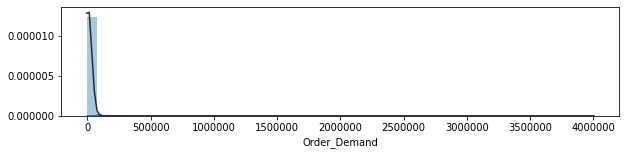

In [26]:
#Lets check the ditribution of the target variable (Order_Demand)
from matplotlib import rcParams
# figure size in inches
rcParams['figure.figsize'] = 10,2

sb.distplot(df['Order_Demand'], fit=norm)


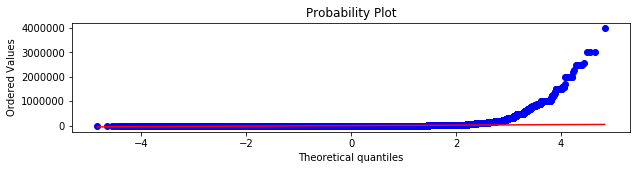

In [24]:
#Get the QQ-plot

fig = plt.figure()
res = stats.probplot(df['Order_Demand'], plot=plt)
plt.show()

In [27]:
#The data is highly skewed, but since we'll be applying ARIMA, So it's fine.
df['Order_Demand'].skew()

31.506080242694996

In [28]:
#Warehouse shipping by orders.

df['Warehouse'].value_counts().sort_values(ascending=True)

Whse_C     42207
Whse_S     88024
Whse_A    142197
Whse_J    764215
Name: Warehouse, dtype: int64

In [29]:
#The amount of orders shipped by each warehouse.

df.groupby('Warehouse').sum().sort_values('Order_Demand', ascending = False)


,Order_Demand
Warehouse,
Whse_J,3362742530
Whse_S,1033121811
Whse_C,582004179
Whse_A,147646550


In [31]:
#Product Category.

print (len(df['Product_Category'].value_counts()))

33


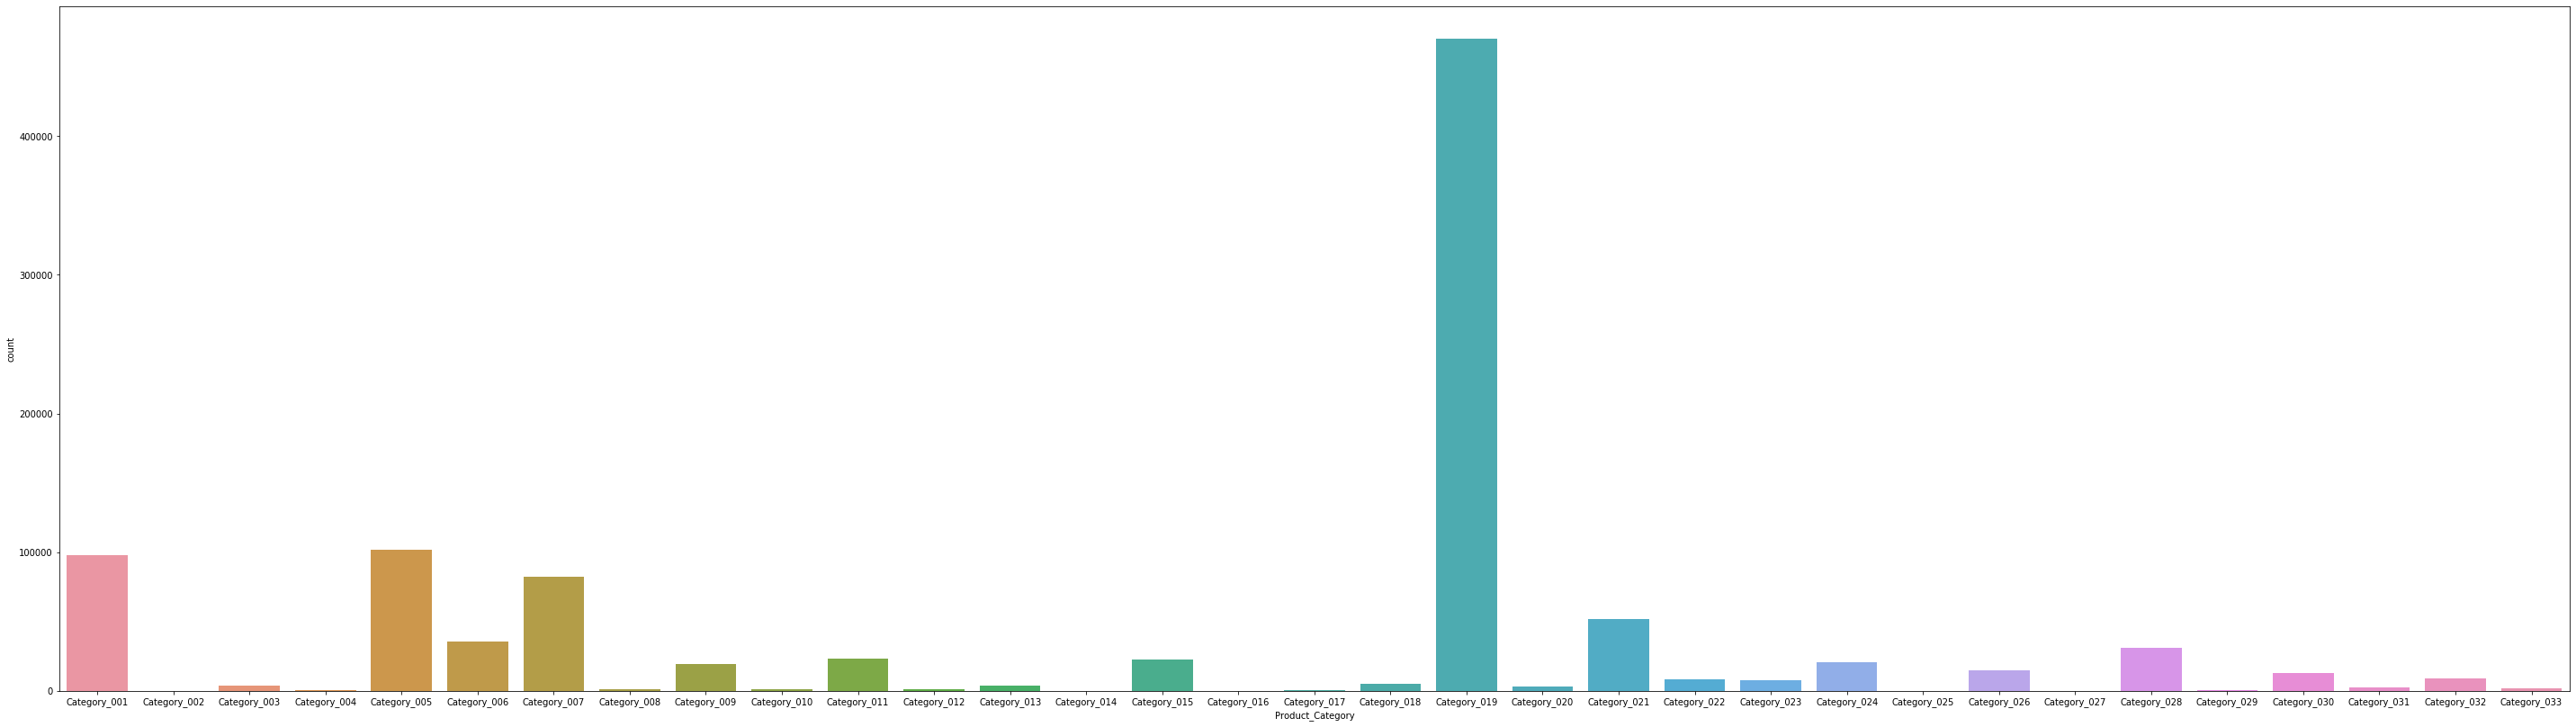

In [35]:
rcParams['figure.figsize'] = 50,14
sb.countplot(df['Product_Category'].sort_values(ascending = True))

In [36]:
df['Order_Demand'].min(), df['Order_Demand'].max()

(0, 4000000)

In [40]:
df.groupby('Order_Demand').sum()

,Product_Code,Warehouse,Product_Category
Order_Demand,,,
0,Product_1461Product_1368Product_0427Product_14...,Whse_AWhse_AWhse_AWhse_AWhse_AWhse_AWhse_AWhse...,Category_019Category_019Category_019Category_0...
1,Product_2168Product_0643Product_0643Product_00...,Whse_SWhse_AWhse_AWhse_AWhse_SWhse_CWhse_AWhse...,Category_024Category_028Category_028Category_0...
2,Product_2166Product_0353Product_0643Product_03...,Whse_SWhse_AWhse_AWhse_AWhse_AWhse_SWhse_SWhse...,Category_024Category_021Category_028Category_0...
3,Product_0614Product_0135Product_2165Product_03...,Whse_SWhse_AWhse_CWhse_AWhse_AWhse_JWhse_JWhse...,Category_001Category_021Category_024Category_0...
4,Product_0613Product_1822Product_0960Product_20...,Whse_SWhse_SWhse_JWhse_JWhse_JWhse_AWhse_JWhse...,Category_001Category_018Category_028Category_0...
...,...,...,...
2300000,Product_1480,Whse_C,Category_019
2500000,Product_1248Product_1432Product_1432Product_14...,Whse_JWhse_SWhse_SWhse_SWhse_S,Category_019Category_019Category_019Category_0...
2560000,Product_1248,Whse_J,Category_019


In [41]:
from matplotlib import rcParams

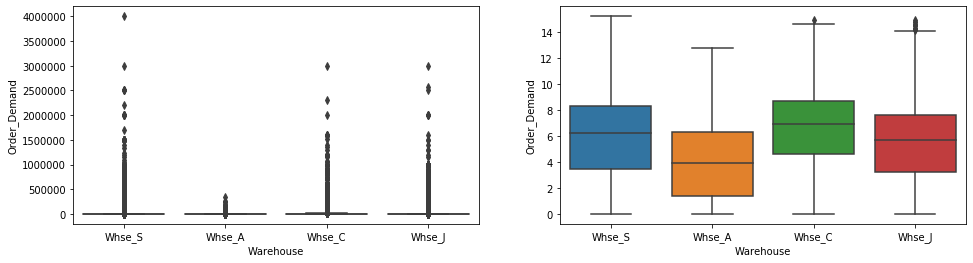

In [47]:
#figure Size
rcParams['figure.figsize'] =16,4
f, axes = plt.subplots(1,2)

#regular data
fig3 = sb.boxplot(df['Warehouse'], df['Order_Demand'], ax = axes[0])

#data with Log transformation

fig4 = sb.boxplot(df['Warehouse'],np.log1p(df['Order_Demand']),ax =axes[1])

del fig3, fig4


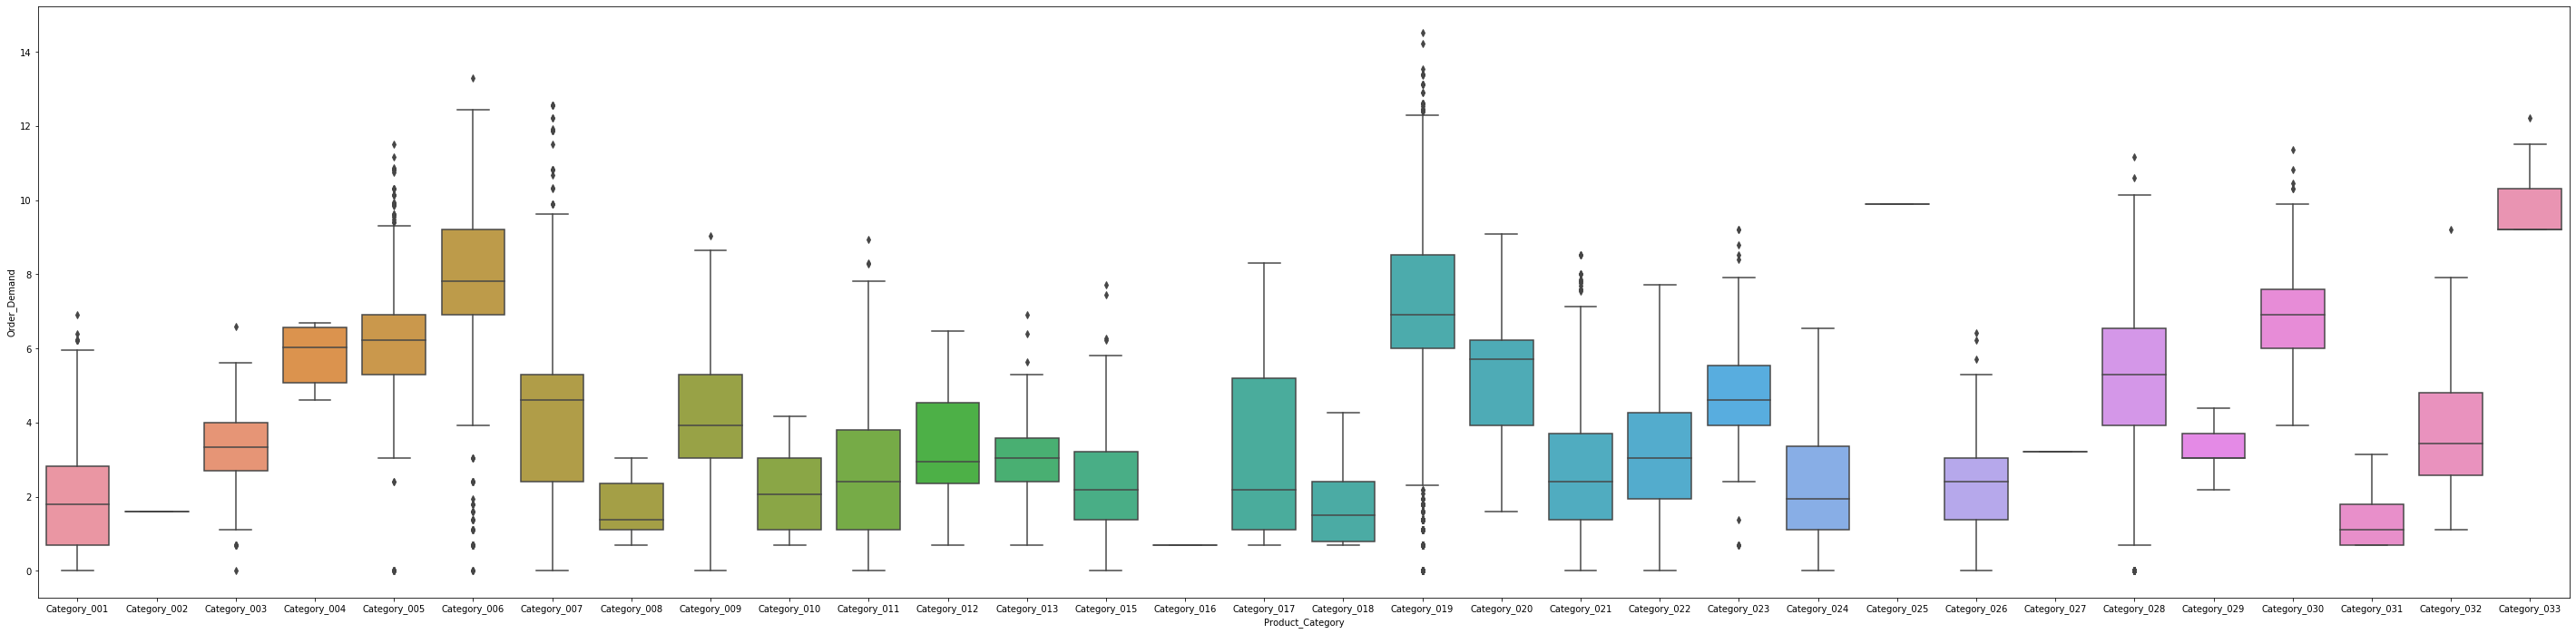

In [48]:
#Lets check the Orders by Product Category.
rcParams['figure.figsize'] = 50,12
#Taking subset of data temporarily for in memory compute.
df_temp = df.sample(n=20000).reset_index()
fig5 = sb.boxplot( df_temp['Product_Category'].sort_values(),np.log1p(df_temp['Order_Demand']))
del df_temp, fig5

In [49]:
#Exploring the Data as TIME SERIES

#The total orders placed on each day.

df = df.groupby('Date')['Order_Demand'].sum().reset_index()

In [50]:
df = df.set_index('Date')
df.index

DatetimeIndex(['2012-01-01', '2012-01-02', '2012-01-03', '2012-01-04',
               '2012-01-05', '2012-01-06', '2012-01-08', '2012-01-09',
               '2012-01-10', '2012-01-11',
               ...
               '2016-12-20', '2016-12-21', '2016-12-22', '2016-12-23',
               '2016-12-25', '2016-12-26', '2016-12-27', '2016-12-28',
               '2016-12-29', '2016-12-30'],
              dtype='datetime64[ns]', name='Date', length=1681, freq=None)

In [51]:
y = df['Order_Demand'].resample('MS').mean()

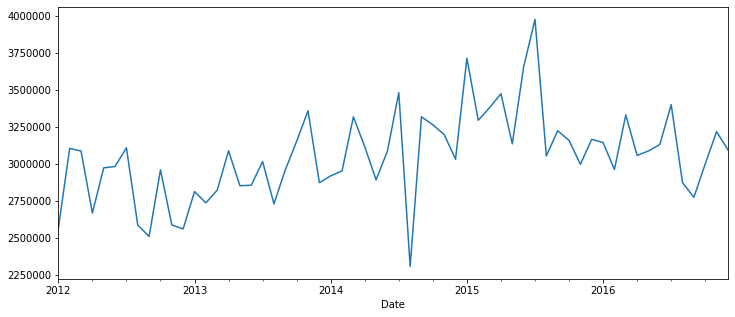

In [53]:
#visulizing time series data

y.plot(figsize=(12,5))
plt.show()


In [54]:
# Here we can see that sales are low at the starting of every year and sales high during the last quarter.

# The observed trend shows that orders were higher during 2014-2016 then reducing.

#Lets check it by decomposition.


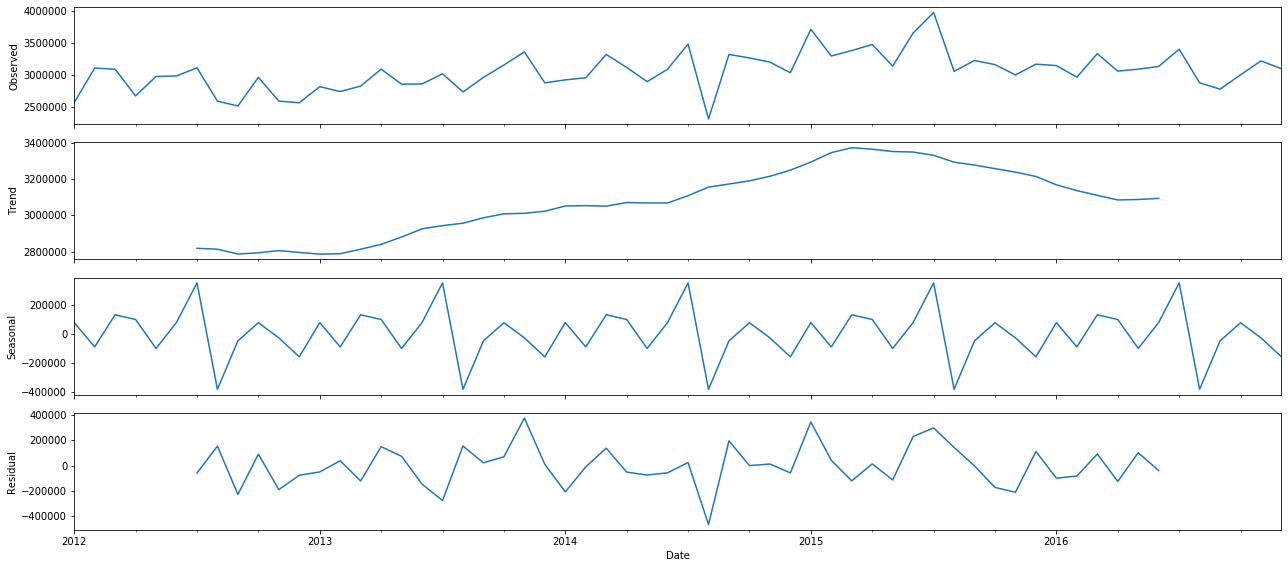

In [55]:
# Decomposition is a great way to check the seasonality, trends and residuals.
# Time series data and decomposition is that you can break down the data into the following:

from pylab import rcParams
import statsmodels.api as sm
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

In [56]:
#GRID SEARCH for Param Tuning.
#Sample params for seasonal arima. (SARIMAX).

#For each combination of parameters, we fit a new seasonal ARIMA model with the SARIMAX() function 
#from the statsmodels module and assess its overall quality.

import itertools
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [57]:
#Get the best params for the data. Choose the lowest AIC.

# AIC measures how well a model fits the data while taking into account the overall complexity of the model.
# Large AIC: Model fits very well using a lot of features.
# Small AIC: Model fits similar fit but using lesser features. 
# Hence LOWER THE AIC, the better


for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('SARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue



SARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1932.23655778549
SARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1512.927583212436
SARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:1338.8201294951011
SARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:2963.162309676349
SARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:1366.5117513512635
SARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1340.8450308457734
SARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:1023.6756022859483
SARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:2987.9309958789995
SARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:1862.0874878045222
SARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:1471.1838032700646
SARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:1305.3289813345482
SARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:2883.609599551857
SARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:1529.1005721650984
SARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:1467.6395590277814
SARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:1020.6347629759124
SARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:2933.8366043265787
SARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:1648.7378898187837
SARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AI

In [62]:
#Fit the model

#ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:960.5164122018646


from statsmodels.tsa.statespace.sarimax import SARIMAX
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print (results.summary())

                                 Statespace Model Results                                 
Dep. Variable:                       Order_Demand   No. Observations:                   60
Model:             SARIMAX(1, 1, 1)x(1, 1, 0, 12)   Log Likelihood                -476.258
Date:                            Fri, 10 Apr 2020   AIC                            960.516
Time:                                    13:40:26   BIC                            966.622
Sample:                                01-01-2012   HQIC                           962.599
                                     - 12-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2450      0.368     -0.666      0.505      -0.966       0.476
ma.L1         -0.4385      0.325   

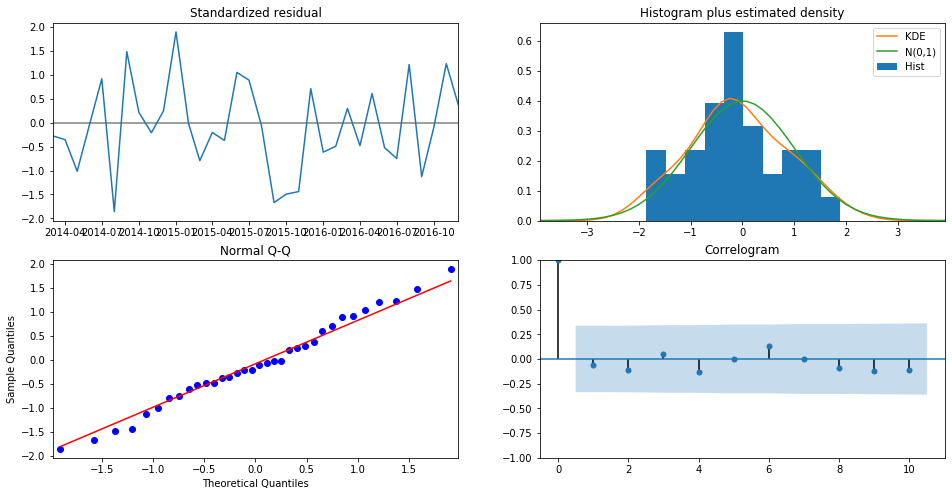

In [63]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

In [64]:
#Residuals SHOULD be Normally Distributed ; Check
#Top Right: The (orange colored) KDE line should be closely matched with green colored N(0,1) line. This is the standard notation
#for normal distribution with mean 0 and sd 1.
#Bottom Left: The qq plot shows the ordered distribution of residuals (blue dots) follows the linear trend of the samples 
#taken from a standard normal distribution with N(0, 1). 

#Residuals are not correlated; Check
#Top Left: The standard residuals don’t display any obvious seasonality and appear to be white noise. 
#Bottom Right: The autocorrelation (i.e. correlogram) plot on the bottom right, which shows that the time series residuals have 
#low correlation with its own lagged versions.

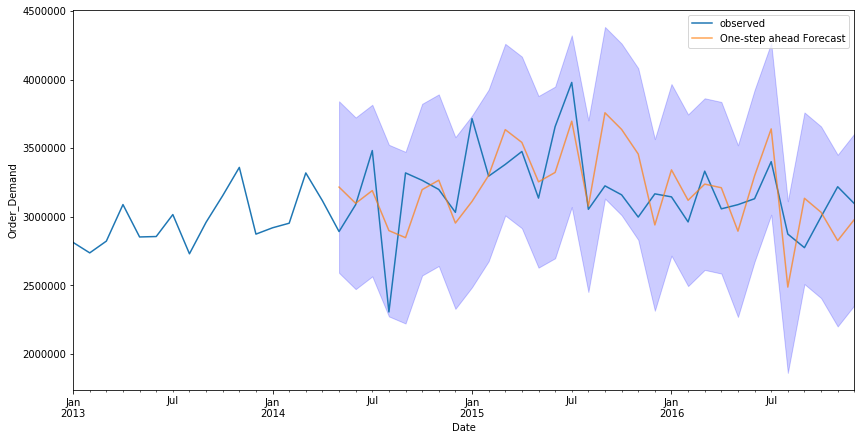

In [66]:
pred = results.get_prediction(start=pd.to_datetime('2014-05-01'), dynamic=False) #false is when using the entire history.
#Confidence interval.
pred_ci = pred.conf_int()

#Plotting real and forecasted values.
ax = y['2013':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='blue', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Order_Demand')
plt.legend()
plt.show()

In [67]:
#Getting the mean squared error (average error of forecasts).
y_forecasted = pred.predicted_mean
y_truth = y['2016-01-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('MSE {}'.format(round(mse, 2)))

print('RMSE: {}'.format(round(np.sqrt(mse), 2)))

MSE 55459437844.5
RMSE: 235498.28


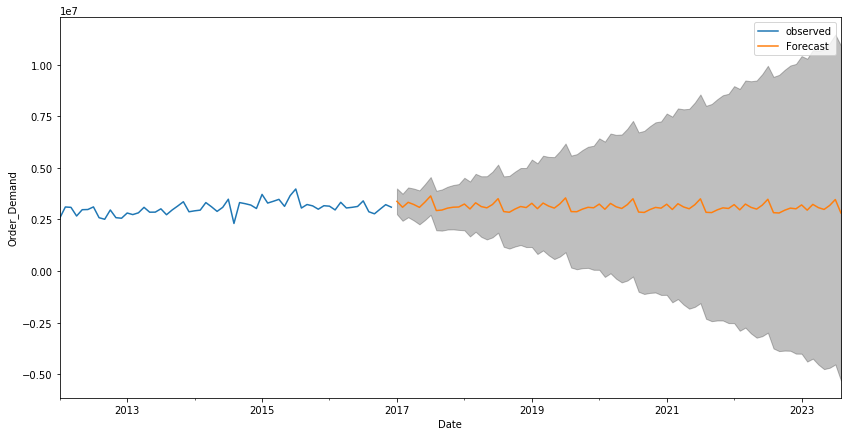

In [69]:
#The Forecasting using steps.

pred_uc = results.get_forecast(steps=80)
pred_ci = pred_uc.conf_int()
ax = y.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Order_Demand')
plt.legend()
plt.show()